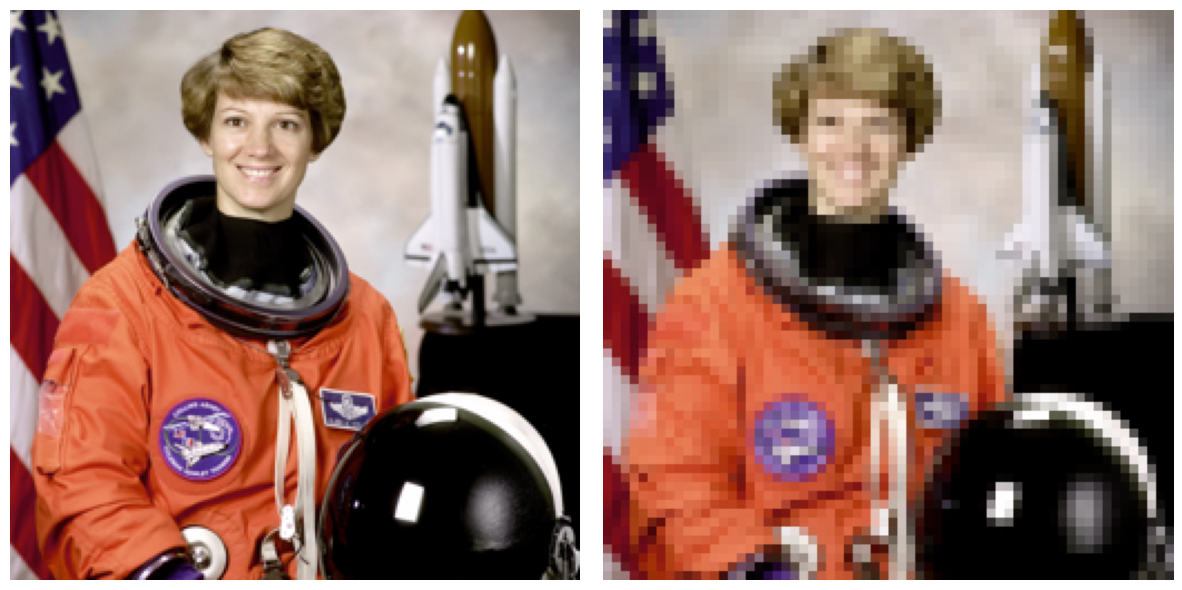

In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import data

# ---------------- utility ----------------
def psnr(a, b, eps=1e-8):
    mse = np.mean((a - b) ** 2)
    return 20 * np.log10(1.0 / np.sqrt(mse + eps))

# ---------------- your SVD-based SuperResolution ----------------
class H_functions:
    """
    A class replacing the SVD of a matrix H, perhaps efficiently.
    All input vectors are of shape (Batch, ...).
    All output vectors are of shape (Batch, DataDimension).
    """

    def V(self, vec):
        """
        Multiplies the input vector by V
        """
        raise NotImplementedError()

    def Vt(self, vec):
        """
        Multiplies the input vector by V transposed
        """
        raise NotImplementedError()

    def U(self, vec):
        """
        Multiplies the input vector by U
        """
        raise NotImplementedError()

    def Ut(self, vec):
        """
        Multiplies the input vector by U transposed
        """
        raise NotImplementedError()

    def singulars(self):
        """
        Returns a vector containing the singular values. The shape of the vector should be the same as the smaller dimension (like U)
        """
        raise NotImplementedError()

    def add_zeros(self, vec):
        """
        Adds trailing zeros to turn a vector from the small dimension (U) to the big dimension (V)
        """
        raise NotImplementedError()
    
    def H(self, vec):
        """
        Multiplies the input vector by H
        """
        temp = self.Vt(vec)
        singulars = self.singulars()
        return self.U(singulars * temp[:, :singulars.shape[0]])
    
    def Ht(self, vec):
        """
        Multiplies the input vector by H transposed
        """
        temp = self.Ut(vec)
        singulars = self.singulars()
        return self.V(self.add_zeros(singulars * temp[:, :singulars.shape[0]]))
    
    def H_pinv(self, vec):
        """
        Multiplies the input vector by the pseudo inverse of H
        """
        temp = self.Ut(vec)
        singulars = self.singulars()
        temp[:, :singulars.shape[0]] = temp[:, :singulars.shape[0]] / singulars
        return self.V(self.add_zeros(temp))

class SuperResolution(H_functions):
    def __init__(self, channels, img_dim, ratio, device): #ratio = 2 or 4
        assert img_dim % ratio == 0
        self.img_dim = img_dim
        self.channels = channels
        self.y_dim = img_dim // ratio
        self.ratio = ratio
        H = torch.Tensor([[1 / ratio**2] * ratio**2]).to(device)
        self.U_small, self.singulars_small, self.V_small = torch.svd(H, some=False)
        self.Vt_small = self.V_small.transpose(0, 1)

    def V(self, vec):
        #reorder the vector back into patches (because singulars are ordered descendingly)
        temp = vec.clone().reshape(vec.shape[0], -1)
        patches = torch.zeros(vec.shape[0], self.channels, self.y_dim**2, self.ratio**2, device=vec.device)
        patches[:, :, :, 0] = temp[:, :self.channels * self.y_dim**2].view(vec.shape[0], self.channels, -1)
        for idx in range(self.ratio**2-1):
            patches[:, :, :, idx+1] = temp[:, (self.channels*self.y_dim**2+idx)::self.ratio**2-1].view(vec.shape[0], self.channels, -1)
        #multiply each patch by the small V
        patches = torch.matmul(self.V_small, patches.reshape(-1, self.ratio**2, 1)).reshape(vec.shape[0], self.channels, -1, self.ratio**2)
        #repatch the patches into an image
        patches_orig = patches.reshape(vec.shape[0], self.channels, self.y_dim, self.y_dim, self.ratio, self.ratio)
        recon = patches_orig.permute(0, 1, 2, 4, 3, 5).contiguous()
        recon = recon.reshape(vec.shape[0], self.channels * self.img_dim ** 2)
        return recon

    def Vt(self, vec):
        #extract flattened patches
        patches = vec.clone().reshape(vec.shape[0], self.channels, self.img_dim, self.img_dim)
        patches = patches.unfold(2, self.ratio, self.ratio).unfold(3, self.ratio, self.ratio)
        unfold_shape = patches.shape
        patches = patches.contiguous().reshape(vec.shape[0], self.channels, -1, self.ratio**2)
        #multiply each by the small V transposed
        patches = torch.matmul(self.Vt_small, patches.reshape(-1, self.ratio**2, 1)).reshape(vec.shape[0], self.channels, -1, self.ratio**2)
        #reorder the vector to have the first entry first (because singulars are ordered descendingly)
        recon = torch.zeros(vec.shape[0], self.channels * self.img_dim**2, device=vec.device)
        recon[:, :self.channels * self.y_dim**2] = patches[:, :, :, 0].view(vec.shape[0], self.channels * self.y_dim**2)
        for idx in range(self.ratio**2-1):
            recon[:, (self.channels*self.y_dim**2+idx)::self.ratio**2-1] = patches[:, :, :, idx+1].view(vec.shape[0], self.channels * self.y_dim**2)
        return recon

    def U(self, vec):
        return self.U_small[0, 0] * vec.clone().reshape(vec.shape[0], -1)

    def Ut(self, vec): #U is 1x1, so U^T = U
        return self.U_small[0, 0] * vec.clone().reshape(vec.shape[0], -1)

    def singulars(self):
        return self.singulars_small.repeat(self.channels * self.y_dim**2)

    def add_zeros(self, vec):
        reshaped = vec.clone().reshape(vec.shape[0], -1)
        temp = torch.zeros((vec.shape[0], reshaped.shape[1] * self.ratio**2), device=vec.device)
        temp[:, :reshaped.shape[1]] = reshaped
        return temp

# ---------------- use a built-in natural RGB image ----------------
img_np = data.astronaut()        # shape (512, 512, 3), dtype uint8
img_np = img_np.astype(np.float32) / 255.0
size = 256                       # crop or resize
img_np = np.array(Image.fromarray((img_np * 255).astype(np.uint8)).resize((size, size))) / 255.0
# Visualize

hr_np = img_np
H_funcs = SuperResolution(channels=3, img_dim=size, ratio=4, device='cpu')
y_0 = H_funcs.H(torch.tensor(hr_np).permute(2, 0, 1).unsqueeze(0).float())
pinv_y_0 = H_funcs.H_pinv(y_0).view(y_0.shape[0], 3, size, size)
lr_np = pinv_y_0.squeeze(0).permute(1, 2, 0).numpy()

plt.figure(figsize=(12,6))
plt.subplot(1,2,1); plt.imshow(hr_np); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(lr_np); plt.axis("off")
plt.tight_layout(); plt.show()